In [50]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.decomposition import PCA

In [51]:
root = "/home/jack/workspace/own/cell-tracker"
data_path = os.path.join(root, "data/")
filepath = os.path.join(data_path, "patterns.tif")

In [52]:
def imshow(image, title='', cmap='gray'):
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.title(title)
    plt.show()

uint8


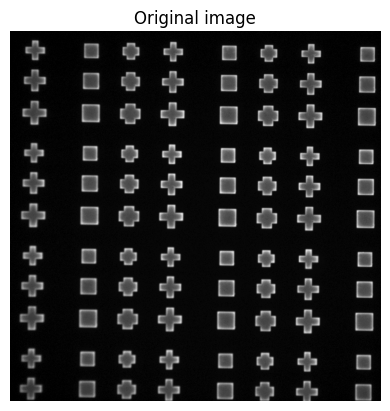

In [53]:
gray_image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
print(gray_image.dtype)
imshow(gray_image, 'Original image')

In [59]:
def get_contour_and_centroids(image):
    
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    _, thresh_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    print(f"Number of contours: {len(contours)}")
    print(f"Contour 0 number of centroids: {len(contours[0])}")
    print(f"Contour 0 starting point: {contours[0][0].squeeze()}")
    print()

    image_with_contours = cv2.drawContours(cv2.cvtColor(thresh_image, cv2.COLOR_GRAY2BGR), contours, -1, (0, 255, 0), 2)

    centroids = []

    for i, c in enumerate(contours):
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
            cv2.circle(image_with_contours, (cX, cY), 5, (0, 0, 255), -1)
        else:
            print(f"Warning: Contour {i} has zero area, skipping centroid calculation.")
            centroids.append(None)

    centroids = np.array(centroids)
    
    print(f"Number of centroids: {len(centroids)}")
    print(f"Centroid 0: {centroids[0]}")
    print()

    imshow(image_with_contours, 'Image with contours and centroids')

    return thresh_image, contours, centroids

Number of contours: 88
Contour 0 number of centroids: 24
Contour 0 starting point: [956 974]

Number of centroids: 88
Centroid 0: [974 997]



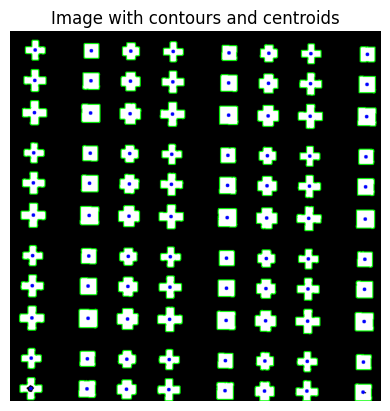

In [60]:
thresh_image, contours, centroids = get_contour_and_centroids(gray_image)

In [56]:
def pca_analysis(centroids, thresh_image):
    
    pca = PCA(n_components=2)
    pca.fit(centroids)
    print("Rotation matrix:")
    print(pca.components_)
    print()

    first_component = pca.components_[0]
    angle_rad = np.arctan2(-first_component[1], first_component[0])
    angle_deg = np.degrees(angle_rad)

    print(f"Detected grid rotation angle: {angle_deg:.2f} degrees")
    print()

    (h, w) = gray_image.shape[:2]
    center = (w // 2, h // 2)
    print(f"Image shape: {gray_image.shape}")
    print(f"Center: {center}")
    print()

    M = cv2.getRotationMatrix2D(center, -angle_deg % 90, 1.0)
    print(f"Affine transformation matrix: ")
    print(M)
    print()

    rotated_image = cv2.warpAffine(thresh_image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    imshow(rotated_image, 'Rotated image')

    return rotated_image

Rotation matrix:
[[-0.01723356  0.99985149]
 [ 0.99985149  0.01723356]]

Detected grid rotation angle: -90.99 degrees

Image shape: (1022, 1024)
Center: (512, 511)

Affine transformation matrix: 
[[ 0.99985149  0.01723356 -8.73031211]
 [-0.01723356  0.99985149  8.89947018]]



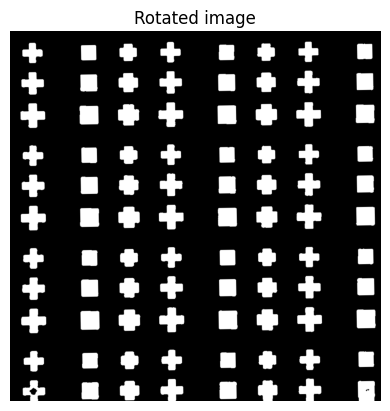

In [57]:
rotated_image = pca_analysis(centroids, thresh_image)

Number of contours: 88
Contour 0 number of centroids: 35
Contour 0 starting point: [202 970]

Number of centroids: 88
Centroid 0: [220 993]



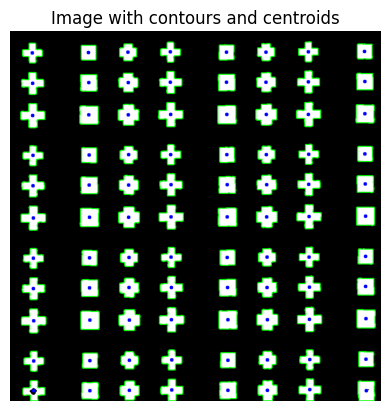

In [ ]:
thresh_image, contours, centroids = get_contour_and_centroids(rotated_image)